   Height  Weight  Age  Gender
0     170      65   30       1
1     165      59   25       0
2     180      75   35       1
3     175      68   28       1
4     160      55   22       0
5     172      70   32       1
6     168      62   27       0
7     177      74   33       1
8     162      58   24       0
9     158      54   21       0


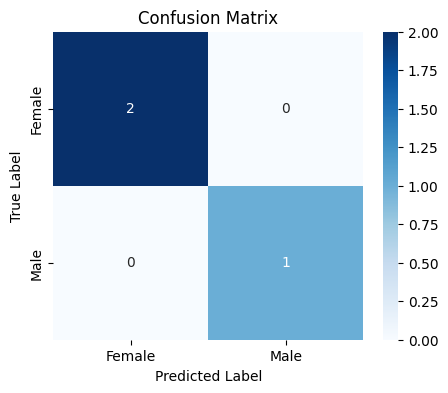

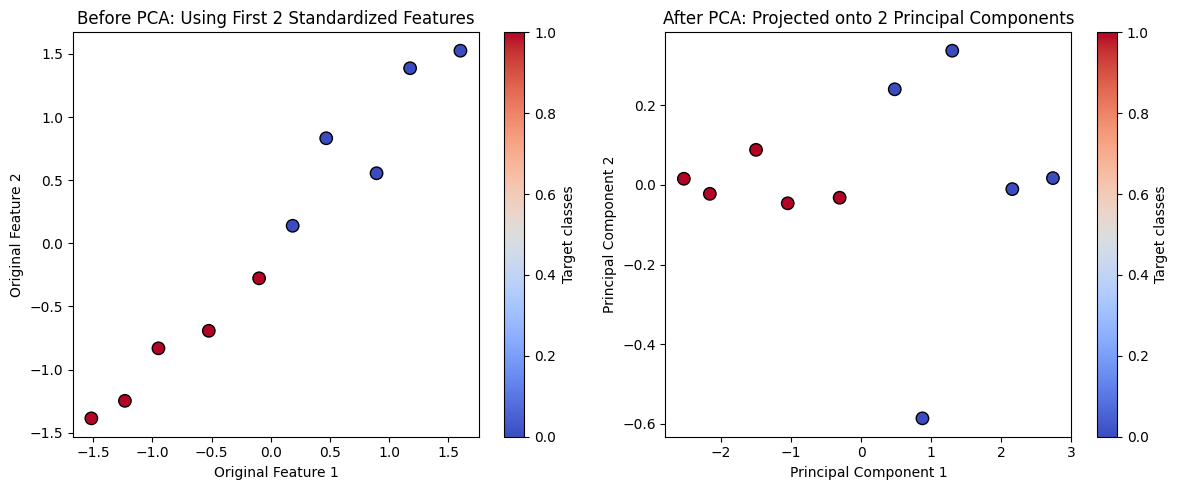

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#Step 2: Creating Sample Dataset
#We make a small dataset with three features Height, Weight, Age and Gender.

data = {
    'Height': [170, 165, 180, 175, 160, 172, 168, 177, 162, 158],
    'Weight': [65, 59, 75, 68, 55, 70, 62, 74, 58, 54],
    'Age': [30, 25, 35, 28, 22, 32, 27, 33, 24, 21],
    'Gender': [1, 0, 1, 1, 0, 1, 0, 1, 0, 0]  # 1 = Male, 0 = Female
}
df = pd.DataFrame(data)
print(df)

#Step 3: Standardizing the Data
#Since the features have different scales Height vs Age we standardize the data. 
# This makes all features have mean = 0 and standard deviation = 1 so that no feature dominates just because of its units.

X = df.drop('Gender', axis=1)
y = df['Gender']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Step 4: Applying PCA algorithm
#We reduce the data from 3 features to 2 new features called principal components. These components capture most of the original information but in fewer dimensions.
#We split the data into 70% training and 30% testing sets.
#We train a logistic regression model on the reduced training data and predict gender labels on the test set.

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

#Step 5: Evaluating with Confusion Matrix
#The confusion matrix compares actual vs predicted labels. This makes it easy to see where predictions were correct or wrong.

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#Step 6: Visualizing PCA Result

y_numeric = pd.factorize(y)[0]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_numeric, cmap='coolwarm', edgecolor='k', s=80)
plt.xlabel('Original Feature 1')
plt.ylabel('Original Feature 2')
plt.title('Before PCA: Using First 2 Standardized Features')
plt.colorbar(label='Target classes')

plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_numeric, cmap='coolwarm', edgecolor='k', s=80)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('After PCA: Projected onto 2 Principal Components')
plt.colorbar(label='Target classes')

plt.tight_layout()
plt.show()



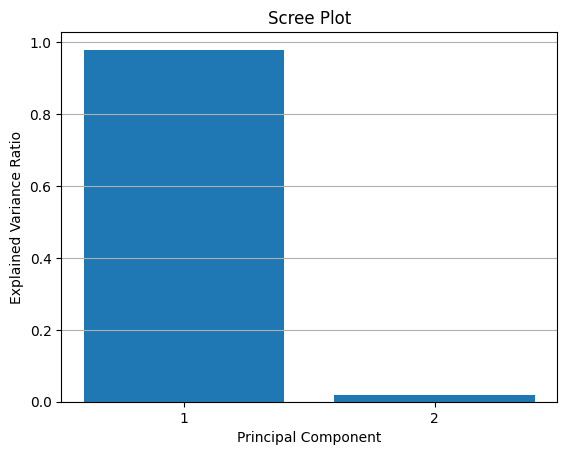

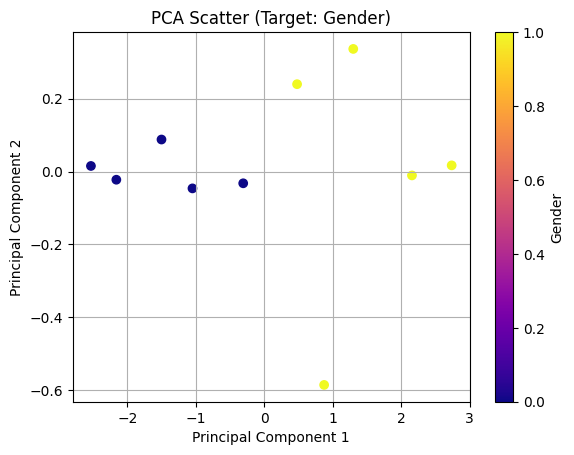

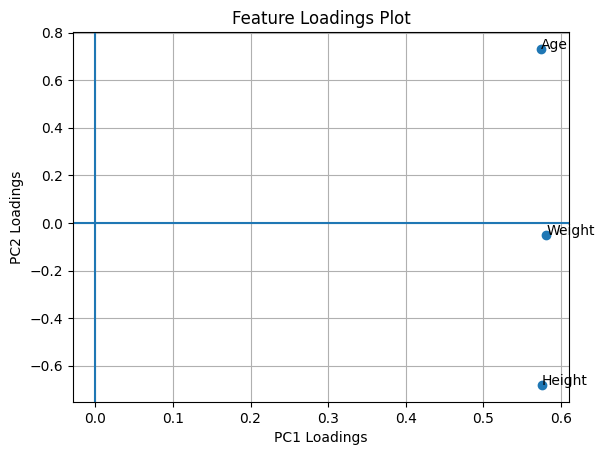


--- Feature Loadings Key ---
Height: PC1=0.576, PC2=-0.681
Weight: PC1=0.581, PC2=-0.049
Age: PC1=0.575, PC2=0.731


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


def pca(file_paths, target_col, feature_cols=None, n_components=2):
   
    if isinstance(file_paths, list):
        df = pd.concat([pd.read_csv(f) for f in file_paths], ignore_index=True)
    else:
        df = pd.read_csv(file_paths)

    # Select the data we actually want
    # If feature_cols isn't provided, default to all numeric columns minus target
    if feature_cols is None:
        features_df = df.select_dtypes(include=[np.number]).drop(columns=[target_col], errors='ignore')
        feature_cols = features_df.columns.tolist()
    else:
        features_df = df[feature_cols]

    # drop rows with NaNs
    clean_df = features_df.join(df[target_col]).dropna()
    features_final = clean_df[features_df.columns]
    target_final = clean_df[target_col].values

    # Scaling & PCA
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(features_final)
    
    pca = PCA(n_components=n_components)
    pca_results = pca.fit_transform(scaled_data) 

    # plots

    # Scree Plot (Explained Variance)
    # Shows the "elbow" to decide how many PCs are enough (how many get 90% is goal)

    plt.figure()
    components = np.arange(1, len(pca.explained_variance_ratio_) + 1)

    plt.bar(components, pca.explained_variance_ratio_)
    plt.xlabel("Principal Component")
    plt.ylabel("Explained Variance Ratio")
    plt.title("Scree Plot")
    plt.xticks(components)
    plt.grid(axis='y')
    plt.show()

    # PCA Contour Plot (PC1 vs PC2 vs Target)
    plt.figure()
    scatter = plt.scatter(
        pca_results[:, 0],
        pca_results[:, 1],
        c=target_final,
        cmap='plasma'
    )

    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title(f"PCA Scatter (Target: {target_col})")
    plt.colorbar(scatter, label=target_col)
    plt.grid(True)
    plt.show()

    # Loadings Plot
    # Shows which original variables "pull" the data in certain directions
    loadings = pca.components_.T
    plt.figure()

    # Draw axes crossing at origin
    plt.axhline(0)
    plt.axvline(0)

    plt.scatter(loadings[:, 0], loadings[:, 1])

    # Label each feature
    for i, feature in enumerate(feature_cols):
        plt.text(loadings[i, 0], loadings[i, 1], feature)

    plt.xlabel("PC1 Loadings")
    plt.ylabel("PC2 Loadings")
    plt.title("Feature Loadings Plot")
    plt.grid(True)
    plt.show()

    # Print loadings numerically too
    print("\n--- Feature Loadings Key ---")
    for i, feature in enumerate(feature_cols):
        print(f"{feature}: PC1={loadings[i, 0]:.3f}, PC2={loadings[i, 1]:.3f}")
  

pca(file_paths='PCA_testing.csv', target_col='Gender', feature_cols=None, n_components=2)




In [ ]:
#https://youtu.be/5vgP05YpKdE?si=DEORs2qyAp_pTuRV
#explanation on how to read pca and the 3 types of plot